## get CSID

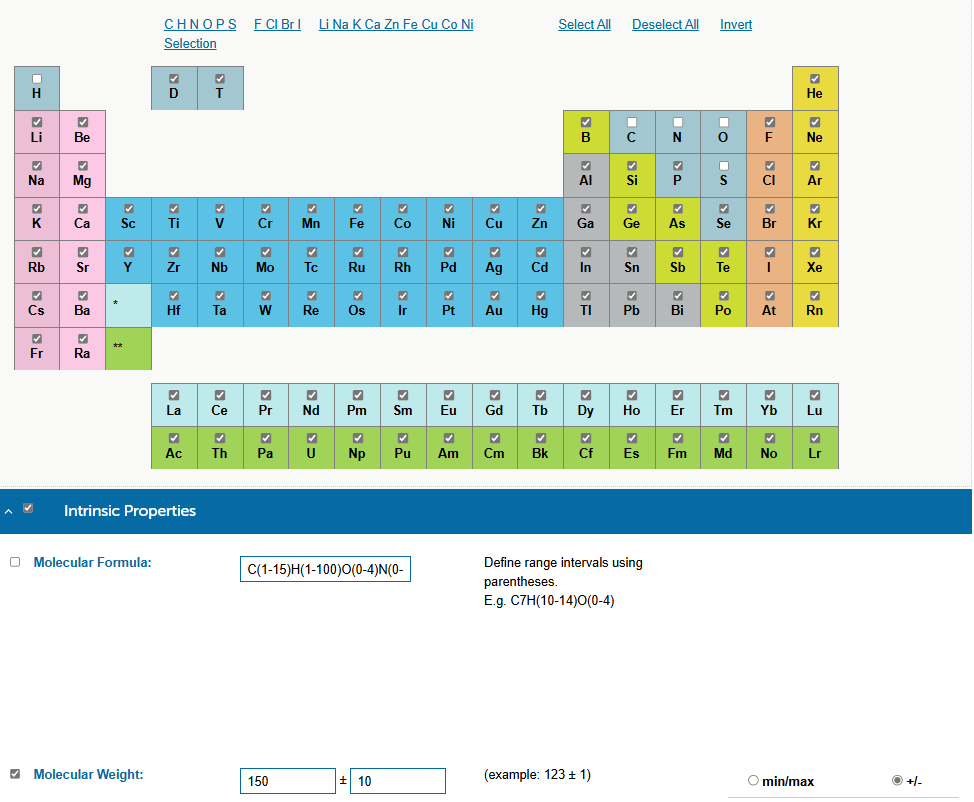

> Search term: -D AND -T AND -He AND -Li AND -Be AND -B AND -F AND -Ne AND -Na AND -Mg AND -Al AND -Si AND -P AND -Cl AND -Ar AND -K AND -Ca AND -Sc AND -Ti AND -V AND -Cr AND -Mn AND -Fe AND -Co AND -Ni AND -Cu AND -Zn AND -Ga AND -Ge AND -As AND -Se AND -Br AND -Kr AND -Rb AND -Sr AND -Y AND -Zr AND -Nb AND -Mo AND -Tc AND -Ru AND -Rh AND -Pd AND -Ag AND -Cd AND -In AND -Sn AND -Sb AND -Te AND -I AND -Xe AND -Cs AND -Ba AND -La AND -Ce AND -Pr AND -Nd AND -Pm AND -Sm AND -Eu AND -Gd AND -Tb AND -Dy AND -Ho AND -Er AND -Tm AND -Yb AND -Lu AND -Hf AND -Ta AND -W AND -Re AND -Os AND -Ir AND -Pt AND -Au AND -Hg AND -Tl AND -Pb AND -Bi AND -Po AND -At AND -Rn AND -Fr AND -Ra AND -Ac AND -Th AND -Pa AND -U AND -Np AND -Pu AND -Am AND -Cm AND -Bk AND -Cf AND -Es AND -Fm AND -Md AND -No AND -Lr AND MF = 'C(1-15)H(1-100)O(0-4)N(0-4)S(0-2)' AND MW >= 140 AND MW <= 160 AND abs(Molecular_Weight - 150) as mass_defect AND SingleComponent AND NonIsotopic

In [1]:
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
import time
from selenium.common.exceptions import NoSuchElementException, StaleElementReferenceException
from tqdm.notebook import tqdm
from selenium.webdriver.chrome.options import Options

#-----------------------------------------------------------------------------------------------#
                                #----------- setup -----------# 
#-----------------------------------------------------------------------------------------------#

# 크롤링할 페이지 정보 입력
LastPage    = 500 # 마지막 페이지 번호
target_url  = "https://www.chemspider.com/Search.aspx?rid=b5a8dc29-5168-4694-a26f-9b24383ea400"


# 대기 시간
#fixed_wait_time = 20
fixed_wait_time = 5
#explicitly_wait_time = 60 # 명시적 최대 대기 시간
explicitly_wait_time = 20 # 명시적 최대 대기 시간
#implicitly_wait_time = 60 # 암시적 최대 대기 시간
implicitly_wait_time = 20 # 암시적 최대 대기 시간

# driver setting
options = Options()
#options.add_argument("--headless")  # headless 모드로 설정
driver = webdriver.Chrome(options=options)
driver.implicitly_wait(implicitly_wait_time)
#-----------------------------------------------------------------------------------------------#


In [2]:
#-----------------------------------------------------------------------------------------------#
                            #----------- functions -----------# 
#-----------------------------------------------------------------------------------------------#
# 현재 페이지의 데이터 web element list 반환 함수
tableWebEle = lambda : driver.find_elements(By.CSS_SELECTOR, ".zebra1.view-grid > tbody > tr")

# 페이지의 pageNum에 대한 web elements list 반환 함수
PageKeyWebEle = lambda : driver.find_elements(By.CSS_SELECTOR, "tfoot > .paginator1 tbody > tr > td")

# 현재 페이지의 pageNum 반환 함수 e.g. (1, 2, 3, ..., 10)
CurrentPages = lambda : tuple(filter(lambda str : str.isdigit(), (ele.text for ele in  PageKeyWebEle())))

def load_checker(PageNum):
    """
    PageNum에 해당하는 Page 로딩이 완료됐는지 확인하는 함수

    Note
    ----
    chemspider page의 특성상 현재 페이지는 currentPages에 포함되지 않음
    """
    time.sleep(2)
    try:
        currentPages = [ele.text for ele in driver.find_elements(By.CSS_SELECTOR, "tfoot > .paginator1 tbody > tr > td > a")]
        if (str(PageNum) not in currentPages) or (PageNum == 1):
            return True
        else:
            return False
    except StaleElementReferenceException or NoSuchElementException:
        return False
#-----------------------------------------------------------------------------------------------#

In [3]:
#-----------------------------------------------------------------------------------------------#

                                #----------- crawler -----------# 

#-----------------------------------------------------------------------------------------------#

# 페이지 로드
driver.get(target_url)
time.sleep(fixed_wait_time*2)

#팝업 허용
try:
    time.sleep(1)
    popup = driver.find_element(By.CSS_SELECTOR, "#onetrust-accept-btn-handler")
    popup.click()
    time.sleep(1)
except:
    pass

# 페이지 이동하며 chemspider ID crawling
first_values = list()
file = open("CSIDs.txt", "w")
for pageNum in tqdm(range(1,LastPage+1)):
    # 현재 클릭 가능한 페이지 목록
    pages = CurrentPages()
    # 찾고자 하는 페이지가 pages에 있는지 확인
    if str(pageNum) in pages:
        pass
    # 없을 경우 다음 페이지로 이동
    else:
        WebDriverWait(driver, explicitly_wait_time).until(EC.element_to_be_clickable(PageKeyWebEle()[-1]))
        PageKeyWebEle()[-1].click()
        time.sleep(fixed_wait_time)
        if str(pageNum) in CurrentPages(): pass
        else : time.sleep(fixed_wait_time)
    # parsing할 페이지 클릭
    PageEle = list(filter(lambda pageEle : str(pageNum) == pageEle.text, PageKeyWebEle()))[0]
    WebDriverWait(driver, explicitly_wait_time).until(EC.element_to_be_clickable(PageEle))
    PageEle.click()
    time.sleep(fixed_wait_time)
    # 페이지 로딩 확인
    trials = 0
    while True:
        if load_checker(pageNum) : break
        else:
            trials += 1
            if trials == explicitly_wait_time: raise Exception("fail to load page. time out") # prevents infinite while loop
    # parsing #
    CSIDs = list(map(lambda rowWebEle : rowWebEle.find_element(By.CSS_SELECTOR, "a").text, tableWebEle()))
    # write file #
    CSIDs_text = "\n".join(CSIDs)
    file.write(CSIDs_text)
    file.write("\n")
    print(f"pageNum : {pageNum} : ", CSIDs)
    # check duplicated values
    first_values.append(CSIDs[0])
    if len(first_values) != len(set(first_values)):
        raise Exception("duplicated value")
file.close()

# 페이지 종료
driver.quit()
#-----------------------------------------------------------------------------------------------#

  0%|          | 0/500 [00:00<?, ?it/s]

pageNum : 1 :  ['70847', '10030', '10498079', '4438593', '29779272', '10498081', '8305559', '24187931', '30687826', '29779334', '3667358', '35807674', '37666228', '60823167', '61108183', '3152632', '19953385', '67172065', '60853772', '61082024']
pageNum : 2 :  ['35523171', '24185492', '24185490', '23980861', '25945534', '61973699', '61973700', '61973701', '61973703', '61984664', '61984665', '62013145', '67031193', '74701701', '76640197', '24222084', '24831734', '60757139', '60792468', '61721628']
pageNum : 3 :  ['81774', '60215', '99181', '3482305', '9058375', '10542979', '11284221', '13824540', '15122276', '15842665', '25935435', '26945068', '73104959', '74701704', '95703202', '95785249', '96942447', '4573634', '5484018']
pageNum : 4 :  ['11591', '8099', '11421', '11580', '205674', '74240', '68403', '144748', '306470', '202066', '121974', '265945', '128427', '4927536', '265944', '465327', '284821', '554626', '4528759', '552423']
pageNum : 5 :  ['9194215', '3873404', '9643988', '813973

## get smiles using chemspider API

### utils

In [1]:
# Chemspider API 관련
from chemspipy import ChemSpider
from chemspipy.errors import ChemSpiPyRateError

# 계산화학 관련
from rdkit import Chem
from rdkit.Chem import AllChem, rdPartialCharges
import ase

# 필요 유틸리티
import random
import pandas as pd
from tqdm.notebook import tqdm
from io import StringIO
import warnings

# defalut setting
warnings.filterwarnings("ignore")
tqdm.pandas()

# your API key list
"""
chemspider API를 이용하기 위해선 API 키를 미리 발급받아야 합니다.
하나의 API 키는 1000 call/month 를 허용하기 때문에 적절한 수의 API 키를 미리 발급받아야 합니다. 저는 10000개 정도의 분자를 다루기 때문에 10개의 API를 발급받았습니다.
"""
from API_KEY import CHEM_SPIDER_API_LIST as API_LIST # API key file
#API_LIST = ["api_1_xxxx", "api_2_xxxx", "api_3_xxxx", "api_4_xxxx", "api_5_xxxx", "api_6_xxxx", "api_7_xxxx", "api_8_xxxx", "api_9_xxxx", "api_10_xxxx"]

# 사용자 정의 함수 utils.py
from utils import smiles2mol, get_properties, get_charge


### call API

In [2]:
'''
(Optional) 분자 정보의 순서를 섞어줌
'''
# read CSIDs.txt file
with open("CSIDs.txt", "r") as file:
    CSIDs = file.readlines()
    CSIDs = list(map(lambda CSID : CSID.strip(), CSIDs))

# shuffle data
random.seed(0)
random.shuffle(CSIDs)

# resave file
with open("CSIDs_shuffle.txt", "w") as file:
    file.write("\n".join(CSIDs))

print("Number of total IDs : ", len(CSIDs))

Number of total IDs :  9777


In [3]:
# Define DataFrame structure
DATA_TABLE = pd.DataFrame(columns=["CSID"], data=CSIDs)
DATA_TABLE["NAME"] = pd.Series()
DATA_TABLE["SMILES"] = pd.Series()
DATA_TABLE["FORMULA"] = pd.Series()

DATA_TABLE.head(3)

,CSID,NAME,SMILES,FORMULA
0,109461980,NaN,NaN,NaN
1,24184605,NaN,NaN,NaN
2,61076502,NaN,NaN,NaN


In [8]:
# API로 분자 정보(이름, smiles, formula) 획득
# 중간에 꺼지면 다시 실행시 이어서 진행됨

for idx in tqdm(DATA_TABLE.index):
    # check previous entries
    if not pd.isna(DATA_TABLE.loc[idx, "NAME"]): continue
    # get properties
    CSID = DATA_TABLE.loc[idx, "CSID"]
    try:
        API_KEY = API_LIST[-1]
        properties = get_properties(API_KEY, CSID)
    except ChemSpiPyRateError:
        if API_LIST: 
            API_LIST.pop()
            API_KEY = API_LIST[-1]
            properties = get_properties(API_KEY, CSID)
        else:
            raise IndexError("There are no available APIs anymore . . .")
    except Exception as e:
        print(f"Error : {e} \nCSID : {CSID}")
        continue
    # add data to DataFrame
    DATA_TABLE.loc[idx, "NAME"] = properties["NAME"]
    DATA_TABLE.loc[idx, "SMILES"] = properties["SMILES"]
    DATA_TABLE.loc[idx, "FORMULA"] = properties["FORMULA"]
# save to csv
DATA_TABLE.to_csv("DATA_TABLE.csv", index=False)

# RUN TIME : 

  0%|          | 0/9777 [00:00<?, ?it/s]

In [3]:
# get mol block, charge

DATA_TABLE = pd.read_csv("DATA_TABLE.csv", engine="python")

# estimate net charge from smiles
DATA_TABLE['charge'] = DATA_TABLE.apply(lambda row: get_charge(row['SMILES']), axis=1)

DATA_TABLE.info()

[13:34:43] Can't kekulize mol.  Unkekulized atoms: 0 1 2 4 5 6 7
[13:34:43] Can't kekulize mol.  Unkekulized atoms: 2 3 4 5 6 7 8 9 10
[13:34:43] WARNING: not removing hydrogen atom without neighbors
[13:34:43] WARNING: not removing hydrogen atom without neighbors
[13:34:43] SMILES Parse Error: syntax error while parsing: COC1=C(C#N)[N+]([O-])=CC=C1
COC1C=CC=[N+]([O-])C=1C#N
[13:34:43] SMILES Parse Error: Failed parsing SMILES 'COC1=C(C#N)[N+]([O-])=CC=C1
COC1C=CC=[N+]([O-])C=1C#N' for input: 'COC1=C(C#N)[N+]([O-])=CC=C1
COC1C=CC=[N+]([O-])C=1C#N'
[13:34:43] SMILES Parse Error: syntax error while parsing: c1cncnc1C(=CO)C=O
C1=CN=CN=C1C(=CO)C=O
[13:34:43] SMILES Parse Error: Failed parsing SMILES 'c1cncnc1C(=CO)C=O
C1=CN=CN=C1C(=CO)C=O' for input: 'c1cncnc1C(=CO)C=O
C1=CN=CN=C1C(=CO)C=O'


[Missing Value Warning] rdkit - ComputeGasteigerCharges may not supports to compute formal charge of n1c(nn2c1cc(n2)C)CC
[Missing Value Warning] rdkit - ComputeGasteigerCharges may not supports to compute formal charge of COc1nc2ncncc2n1
[Missing Value Warning] rdkit - ComputeGasteigerCharges may not supports to compute formal charge of COC1=C(C#N)[N+]([O-])=CC=C1
COC1C=CC=[N+]([O-])C=1C#N
[Missing Value Warning] rdkit - ComputeGasteigerCharges may not supports to compute formal charge of c1cncnc1C(=CO)C=O
C1=CN=CN=C1C(=CO)C=O


[13:34:43] Can't kekulize mol.  Unkekulized atoms: 6 7 8 9 10
[13:34:43] Can't kekulize mol.  Unkekulized atoms: 6 7 8 9 10


[Missing Value Warning] rdkit - ComputeGasteigerCharges may not supports to compute formal charge of C/C2=C/C(=O)Oc1nncc12
[Missing Value Warning] rdkit - ComputeGasteigerCharges may not supports to compute formal charge of CC(=O)NCCc1[c-]ccc1


[13:34:43] SMILES Parse Error: syntax error while parsing: CC1=NC(=N)N2CCNC2=C1
CC1C=C2NCCN2C(=N)N=1
[13:34:43] SMILES Parse Error: Failed parsing SMILES 'CC1=NC(=N)N2CCNC2=C1
CC1C=C2NCCN2C(=N)N=1' for input: 'CC1=NC(=N)N2CCNC2=C1
CC1C=C2NCCN2C(=N)N=1'
[13:34:44] SMILES Parse Error: syntax error while parsing: O1C[C@@H](C2=C1C(=CC=C2)N)N
c1cc2c(c(c1)N)OC[C@@H]2N
[13:34:44] SMILES Parse Error: Failed parsing SMILES 'O1C[C@@H](C2=C1C(=CC=C2)N)N
c1cc2c(c(c1)N)OC[C@@H]2N' for input: 'O1C[C@@H](C2=C1C(=CC=C2)N)N
c1cc2c(c(c1)N)OC[C@@H]2N'


[Missing Value Warning] rdkit - ComputeGasteigerCharges may not supports to compute formal charge of CC1=NC(=N)N2CCNC2=C1
CC1C=C2NCCN2C(=N)N=1
[Missing Value Warning] rdkit - ComputeGasteigerCharges may not supports to compute formal charge of O1C[C@@H](C2=C1C(=CC=C2)N)N
c1cc2c(c(c1)N)OC[C@@H]2N


[13:34:44] Can't kekulize mol.  Unkekulized atoms: 6 7 8 9 10
[13:34:44] SMILES Parse Error: syntax error while parsing: C1=CN2C(=N1)C=C(N2)C(=O)N
NC(=O)C1=CC2=NC=CN2N1
[13:34:44] SMILES Parse Error: Failed parsing SMILES 'C1=CN2C(=N1)C=C(N2)C(=O)N
NC(=O)C1=CC2=NC=CN2N1' for input: 'C1=CN2C(=N1)C=C(N2)C(=O)N
NC(=O)C1=CC2=NC=CN2N1'
[13:34:44] SMILES Parse Error: syntax error while parsing: c1cnc(cn1)C(=CO)C=O
C1=CN=C(C=N1)C(=CO)C=O
[13:34:44] SMILES Parse Error: Failed parsing SMILES 'c1cnc(cn1)C(=CO)C=O
C1=CN=C(C=N1)C(=CO)C=O' for input: 'c1cnc(cn1)C(=CO)C=O
C1=CN=C(C=N1)C(=CO)C=O'


[Missing Value Warning] rdkit - ComputeGasteigerCharges may not supports to compute formal charge of O=C2[N-]C(=O)Nc1ccnc12
[Missing Value Warning] rdkit - ComputeGasteigerCharges may not supports to compute formal charge of C1=CN2C(=N1)C=C(N2)C(=O)N
NC(=O)C1=CC2=NC=CN2N1
[Missing Value Warning] rdkit - ComputeGasteigerCharges may not supports to compute formal charge of O=C1NC2=CC=CC=C2C1=[OH+3]
[Missing Value Warning] rdkit - ComputeGasteigerCharges may not supports to compute formal charge of c1cnc(cn1)C(=CO)C=O
C1=CN=C(C=N1)C(=CO)C=O


[13:34:44] SMILES Parse Error: syntax error while parsing: [C@]1(C(NCC1)=O)(C2CC2)C#N
C1CC1[C@@]2(CCNC2=O)C#N
[13:34:44] SMILES Parse Error: Failed parsing SMILES '[C@]1(C(NCC1)=O)(C2CC2)C#N
C1CC1[C@@]2(CCNC2=O)C#N' for input: '[C@]1(C(NCC1)=O)(C2CC2)C#N
C1CC1[C@@]2(CCNC2=O)C#N'
[13:34:44] SMILES Parse Error: syntax error while parsing: C(\C)(/C=1C=CC(=CN1)C)=N\O
Cc1ccc(nc1)/C(=N/O)/C
[13:34:44] SMILES Parse Error: Failed parsing SMILES 'C(\C)(/C=1C=CC(=CN1)C)=N\O
Cc1ccc(nc1)/C(=N/O)/C' for input: 'C(\C)(/C=1C=CC(=CN1)C)=N\O
Cc1ccc(nc1)/C(=N/O)/C'
[13:34:44] SMILES Parse Error: syntax error while parsing: O=C1NC2=C(C=NC=C2)CO1
O=C1NC2C=CN=CC=2CO1
[13:34:44] SMILES Parse Error: Failed parsing SMILES 'O=C1NC2=C(C=NC=C2)CO1
O=C1NC2C=CN=CC=2CO1' for input: 'O=C1NC2=C(C=NC=C2)CO1
O=C1NC2C=CN=CC=2CO1'
[13:34:44] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 10
[13:34:44] Can't kekulize mol.  Unkekulized atoms: 3 4 5 7 8 9 10
[13:34:44] Can't kekulize mol.  Unkekulized atoms: 3 4 5 

[Missing Value Warning] rdkit - ComputeGasteigerCharges may not supports to compute formal charge of [C@]1(C(NCC1)=O)(C2CC2)C#N
C1CC1[C@@]2(CCNC2=O)C#N
[Missing Value Warning] rdkit - ComputeGasteigerCharges may not supports to compute formal charge of C(\C)(/C=1C=CC(=CN1)C)=N\O
Cc1ccc(nc1)/C(=N/O)/C
[Missing Value Warning] rdkit - ComputeGasteigerCharges may not supports to compute formal charge of O=C1NC2=C(C=NC=C2)CO1
O=C1NC2C=CN=CC=2CO1
[Missing Value Warning] rdkit - ComputeGasteigerCharges may not supports to compute formal charge of Oc1cnnc2nnc(C)c12
[Missing Value Warning] rdkit - ComputeGasteigerCharges may not supports to compute formal charge of [O-]C(=O)c2cc1occc1n2
[Missing Value Warning] rdkit - ComputeGasteigerCharges may not supports to compute formal charge of CC(=O)c1nnc2CCCc12


[13:34:44] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 6 7
[13:34:45] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 9
[13:34:45] SMILES Parse Error: syntax error while parsing: CC1=C2OC(=O)NC2=NC=C1
CC1C=CN=C2NC(=O)OC2=1
[13:34:45] SMILES Parse Error: Failed parsing SMILES 'CC1=C2OC(=O)NC2=NC=C1
CC1C=CN=C2NC(=O)OC2=1' for input: 'CC1=C2OC(=O)NC2=NC=C1
CC1C=CN=C2NC(=O)OC2=1'


[Missing Value Warning] rdkit - ComputeGasteigerCharges may not supports to compute formal charge of n2c1c(cnn1nc2C)CC
[Missing Value Warning] rdkit - ComputeGasteigerCharges may not supports to compute formal charge of n2cnc(c1ccsc1)c2
[Missing Value Warning] rdkit - ComputeGasteigerCharges may not supports to compute formal charge of CC1=C2OC(=O)NC2=NC=C1
CC1C=CN=C2NC(=O)OC2=1


[13:34:45] SMILES Parse Error: syntax error while parsing: CC\1CC2=C(C=CN2)/C1=N/O
CC1CC2NC=CC=2/C/1=N/O
[13:34:45] SMILES Parse Error: Failed parsing SMILES 'CC\1CC2=C(C=CN2)/C1=N/O
CC1CC2NC=CC=2/C/1=N/O' for input: 'CC\1CC2=C(C=CN2)/C1=N/O
CC1CC2NC=CC=2/C/1=N/O'
[13:34:45] Can't kekulize mol.  Unkekulized atoms: 2 3 4 5 6


[Missing Value Warning] rdkit - ComputeGasteigerCharges may not supports to compute formal charge of CC\1CC2=C(C=CN2)/C1=N/O
CC1CC2NC=CC=2/C/1=N/O
[Missing Value Warning] rdkit - ComputeGasteigerCharges may not supports to compute formal charge of N#Cc1c(nc(n1)C(C)C)N


[13:34:45] SMILES Parse Error: syntax error while parsing: COC1=CC(C=C)=CC(O)=C1
COC1C=C(O)C=C(C=C)C=1
[13:34:45] SMILES Parse Error: Failed parsing SMILES 'COC1=CC(C=C)=CC(O)=C1
COC1C=C(O)C=C(C=C)C=1' for input: 'COC1=CC(C=C)=CC(O)=C1
COC1C=C(O)C=C(C=C)C=1'
[13:34:45] Can't kekulize mol.  Unkekulized atoms: 1 2 3 5 6 7 8
[13:34:45] Can't kekulize mol.  Unkekulized atoms: 0 1 2 4 5 6 7
[13:34:45] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 10
[13:34:45] SMILES Parse Error: syntax error while parsing: c1cc(cc(c1)C(=N)N)CO
C1=CC(=CC(=C1)C(=N)N)CO
[13:34:45] SMILES Parse Error: Failed parsing SMILES 'c1cc(cc(c1)C(=N)N)CO
C1=CC(=CC(=C1)C(=N)N)CO' for input: 'c1cc(cc(c1)C(=N)N)CO
C1=CC(=CC(=C1)C(=N)N)CO'


[Missing Value Warning] rdkit - ComputeGasteigerCharges may not supports to compute formal charge of COC1=CC(C=C)=CC(O)=C1
COC1C=C(O)C=C(C=C)C=1
[Missing Value Warning] rdkit - ComputeGasteigerCharges may not supports to compute formal charge of Cc1cnn2nc(nc12)CC
[Missing Value Warning] rdkit - ComputeGasteigerCharges may not supports to compute formal charge of n1c(nn2c1cc(n2)CC)C
[Missing Value Warning] rdkit - ComputeGasteigerCharges may not supports to compute formal charge of Cc1cc2nnc(CC)n2n1
[Missing Value Warning] rdkit - ComputeGasteigerCharges may not supports to compute formal charge of c1cc(cc(c1)C(=N)N)CO
C1=CC(=CC(=C1)C(=N)N)CO


[13:34:45] SMILES Parse Error: syntax error while parsing: c1ccc2c(c1)C(CO2)NN
C1C(C2=CC=CC=C2O1)NN
[13:34:45] SMILES Parse Error: Failed parsing SMILES 'c1ccc2c(c1)C(CO2)NN
C1C(C2=CC=CC=C2O1)NN' for input: 'c1ccc2c(c1)C(CO2)NN
C1C(C2=CC=CC=C2O1)NN'
[13:34:46] Can't kekulize mol.  Unkekulized atoms: 4 5 6 9 10
[13:34:46] SMILES Parse Error: syntax error while parsing: COC1CS[C@@H](CO)O1
COC1CS[C@H](O1)CO
[13:34:46] SMILES Parse Error: Failed parsing SMILES 'COC1CS[C@@H](CO)O1
COC1CS[C@H](O1)CO' for input: 'COC1CS[C@@H](CO)O1
COC1CS[C@H](O1)CO'
[13:34:46] SMILES Parse Error: syntax error while parsing: Cc1ccc(c(c1)O)C(=N)N
CC1=CC(=C(C=C1)C(=N)N)O
[13:34:46] SMILES Parse Error: Failed parsing SMILES 'Cc1ccc(c(c1)O)C(=N)N
CC1=CC(=C(C=C1)C(=N)N)O' for input: 'Cc1ccc(c(c1)O)C(=N)N
CC1=CC(=C(C=C1)C(=N)N)O'
[13:34:46] Can't kekulize mol.  Unkekulized atoms: 6 7 8 9 10


[Missing Value Warning] rdkit - ComputeGasteigerCharges may not supports to compute formal charge of c1ccc2c(c1)C(CO2)NN
C1C(C2=CC=CC=C2O1)NN
[Missing Value Warning] rdkit - ComputeGasteigerCharges may not supports to compute formal charge of O=C(OC)c1cc(C#N)cn1
[Missing Value Warning] rdkit - ComputeGasteigerCharges may not supports to compute formal charge of COC1CS[C@@H](CO)O1
COC1CS[C@H](O1)CO
[Missing Value Warning] rdkit - ComputeGasteigerCharges may not supports to compute formal charge of Cc1ccc(c(c1)O)C(=N)N
CC1=CC(=C(C=C1)C(=N)N)O
[Missing Value Warning] rdkit - ComputeGasteigerCharges may not supports to compute formal charge of [N@H]=C(N)C2CC2c1cncn1
[Missing Value Warning] rdkit - ComputeGasteigerCharges may not supports to compute formal charge of O=C1CCCCc2nncc12
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9777 entries, 0 to 9776
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   CSID     9777 non-null  

[13:34:46] Can't kekulize mol.  Unkekulized atoms: 6 7 8 9 10


In [4]:
DATA_TABLE['NAME'] = DATA_TABLE.apply(lambda row: f"name_{row['CSID']}" if pd.isnull(row['NAME']) else row['NAME'], axis=1) # 결측치 처리 --> "name_CSID" 로 변경

DATA_TABLE.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9777 entries, 0 to 9776
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   CSID     9777 non-null   int64  
 1   NAME     9777 non-null   object 
 2   SMILES   9777 non-null   object 
 3   FORMULA  9777 non-null   object 
 4   charge   9743 non-null   float64
dtypes: float64(1), int64(1), object(3)
memory usage: 382.0+ KB


In [5]:
# smiles 오류로 missing value가 있는 행은 삭제 처리
DATA_TABLE.dropna(inplace=True)


In [7]:
# 전하 분포 확인
DATA_TABLE.charge.value_counts()

charge
 0.0    9599
 1.0      77
-1.0      54
-2.0       7
-4.0       3
 2.0       2
 3.0       1
Name: count, dtype: int64

In [8]:
# -2 ~ +2 전하에 대해서 진행

# 삭제할 분자 확인
DATA_TABLE.loc[(DATA_TABLE["charge"] >= 3) | (DATA_TABLE["charge"] <= -3)]
# remove (chrg >= 3) or (chrg =< -3)
DATA_TABLE = DATA_TABLE[(DATA_TABLE["charge"] < 3) & (DATA_TABLE["charge"] > -3)]

# check missing values
DATA_TABLE.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9739 entries, 0 to 9776
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   CSID     9739 non-null   int64  
 1   NAME     9739 non-null   object 
 2   SMILES   9739 non-null   object 
 3   FORMULA  9739 non-null   object 
 4   charge   9739 non-null   float64
dtypes: float64(1), int64(1), object(3)
memory usage: 456.5+ KB


In [9]:
DATA_TABLE.to_csv("DATA_TABLE_charge.csv", index=False)